## Import Libraries and Load the Data

Libraries to install
- tensorflow
- tensorflow-gpu
- tensorflow_io==0.23.1

In [ ]:
pip install tensorflow_io==0.23.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 23.1 MB 10.0 MB/s 
     |████████████████████████████████| 2.1 MB 51.6 MB/s 
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.26.0
    Uninstalling tensorflow-io-gcs-filesystem-0.26.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.26.0


In [ ]:
# Import required libraries
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 !unzip '/content/drive/MyDrive/Colab Notebooks/Dataset/Audio.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/Dataset/Audio.zip
   creating: Dataset/Forest Recordings/
  inflating: Dataset/Forest Recordings/recording_00.mp3  
  inflating: Dataset/Forest Recordings/recording_01.mp3  
  inflating: Dataset/Forest Recordings/recording_02.mp3  
  inflating: Dataset/Forest Recordings/recording_03.mp3  
  inflating: Dataset/Forest Recordings/recording_04.mp3  
  inflating: Dataset/Forest Recordings/recording_05.mp3  
  inflating: Dataset/Forest Recordings/recording_06.mp3  
  inflating: Dataset/Forest Recordings/recording_07.mp3  
  inflating: Dataset/Forest Recordings/recording_08.mp3  
  inflating: Dataset/Forest Recordings/recording_09.mp3  
  inflating: Dataset/Forest Recordings/recording_10.mp3  
  inflating: Dataset/Forest Recordings/recording_11.mp3  
  inflating: Dataset/Forest Recordings/recording_12.mp3  
  inflating: Dataset/Forest Recordings/recording_13.mp3  
  inflating: Dataset/Forest Recordings/recording_14.mp3  
  inflating: Dataset/Fo

In [ ]:
# Defining paths to the data files
path = "/content/Dataset"
Capuchin_File = os.path.join(path, 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
Not_CapuchinFile = os.path.join(path, 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [ ]:
# Loading the data
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename) # Load encoded wav file, output will be in strinig format
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1) # them we decode wav file with mono audio
    wav = tf.squeeze(wav, axis=-1) # Removes trailing axis, rep of amplitude of the wave
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

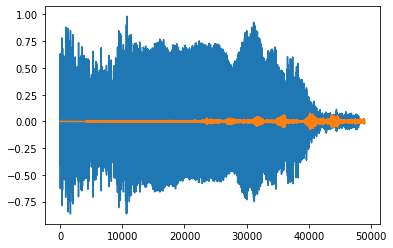

In [ ]:
# Plot the wave
wave = load_wav_16k_mono(Capuchin_File) 
nwave = load_wav_16k_mono(Not_CapuchinFile)
plt.plot(wave) #blue wave
plt.plot(nwave) #orange wave
plt.show()

## Creating Tensorflow Dataset

In [ ]:
import pathlib
data_dir = '/content/Dataset'
data_dir = pathlib.Path(data_dir)

In [ ]:
# Defining paths to positive and negative data
POS = os.path.join(path, 'Parsed_Capuchinbird_Clips')
NEG = os.path.join(path,'Parsed_Not_Capuchinbird_Clips')

In [ ]:
# by this we get set of files as string inside of a tf data format which are able to pre-process them
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [ ]:
# Then add labels to each folder
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

## Determine Average Length of a Capuchin Call

In [ ]:
lengths = []
for file in os.listdir(os.path.join(path, 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join(path, 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [ ]:
print('Mean:' ,tf.math.reduce_mean(lengths))
print('Minimum:', tf.math.reduce_min(lengths))
print('Maximum: ', tf.math.reduce_max(lengths))

Mean: tf.Tensor(54156, shape=(), dtype=int32)
Minimum: tf.Tensor(32000, shape=(), dtype=int32)
Maximum:  tf.Tensor(80000, shape=(), dtype=int32)


## Converting wavefoms into spectrograms 

In [ ]:
# Inorder to transform into spectrograms we use tf and short-term fourier transform 
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [ ]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [ ]:
filepath, label = negative.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

## Splitting the data into train and test

In [ ]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [ ]:
train = data.take(36) # training data to train the model 70%
test = data.skip(36).take(15) # Testing data to test the model 30%

In [ ]:
samples, labels = train.as_numpy_iterator().next()

In [ ]:
samples.shape

(16, 1491, 257, 1)

## Model Building

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten,MaxPooling2D, Dropout

In [ ]:
model = Sequential([Conv2D(filters=16,kernel_size=(3,3),padding='same',input_shape=(1491,257,1),activation='relu'),
                    MaxPooling2D(pool_size=(2,2)),
                    Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu'),
                    MaxPooling2D(pool_size=(2,2)),
                    Flatten(),
                    Dense(128,activation = 'relu'),
                    Dense(1,activation='sigmoid')])

In [ ]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1491, 257, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 745, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 745, 128, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 372, 64, 16)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 380928)            0         
                                                                 
 dense (Dense)               (None, 128)               4

In [ ]:
history = model.fit(train, epochs=5, validation_data=test)

Epoch 1/5
36/36 [==============================] - 17s 122ms/step - loss: 0.7121 - recall: 0.8854 - precision: 0.7989 - val_loss: 0.0332 - val_recall: 0.9855 - val_precision: 0.9714
Epoch 2/5
36/36 [==============================] - 4s 119ms/step - loss: 0.0436 - recall: 0.9595 - precision: 0.9930 - val_loss: 0.0134 - val_recall: 0.9848 - val_precision: 1.0000
Epoch 3/5
36/36 [==============================] - 4s 108ms/step - loss: 0.0063 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0018 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/5
36/36 [==============================] - 4s 108ms/step - loss: 0.0062 - recall: 0.9935 - precision: 1.0000 - val_loss: 0.0037 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 5/5
36/36 [==============================] - 4s 108ms/step - loss: 0.0025 - recall: 1.0000 - precision: 1.0000 - val_loss: 6.1627e-04 - val_recall: 1.0000 - val_precision: 1.0000


In [ ]:
model.save('model.h5')

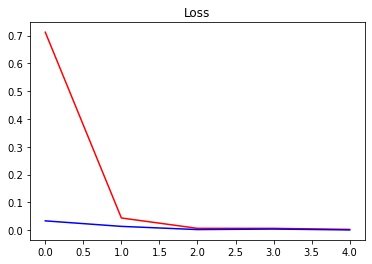

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.show()

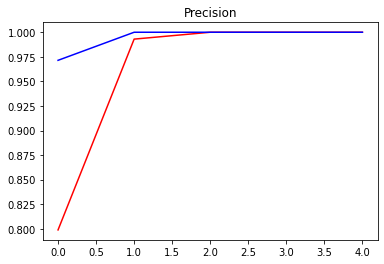

In [ ]:
plt.title('Precision')
plt.plot(history.history['precision'], 'r')
plt.plot(history.history['val_precision'], 'b')
plt.show()

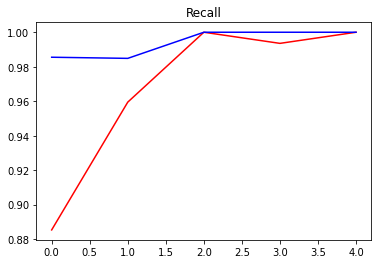

In [ ]:
plt.title('Recall')
plt.plot(history.history['recall'], 'r')
plt.plot(history.history['val_recall'], 'b')
plt.show()

## Making Predictions

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred = [1 if prediction > 0.5 else 0 for prediction in y_pred]

## Build Forest Parsing Functions

In [ ]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
mp3 = os.path.join(path, 'Forest Recordings', 'recording_00.mp3')

In [ ]:
wav = load_mp3_16k_mono(mp3)
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
samples, index = audio_slices.as_numpy_iterator().next()

In [ ]:
#  Build Function to Convert Clips into Windowed Spectrograms
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [ ]:
# Convert Longer Clips into Windows
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
# Making Predictions on new data
ypred = model.predict(audio_slices)
ypred = [1 if prediction > 0.5 else 0 for prediction in ypred]

In [ ]:
# Group Consecutive Detections
from itertools import groupby
ypred = [key for key, group in groupby(ypred)]
calls = tf.math.reduce_sum(ypred).numpy()
calls

5

## Making Predictions

In [ ]:
# Loop over all recordings and make predictions
results = {}
for file in os.listdir(os.path.join(path, 'Forest Recordings')):
    FILEPATH = os.path.join(path,'Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat
print(results)

{'recording_60.mp3': array([[1.60209745e-11],
       [3.85899028e-07],
       [5.57301991e-12],
       [1.96856540e-08],
       [1.72812724e-05],
       [1.00000000e+00],
       [2.01098915e-09],
       [2.44385035e-07],
       [5.85496900e-06],
       [1.00184629e-07],
       [9.34526157e-18],
       [1.00000000e+00],
       [6.75611842e-14],
       [4.14222825e-08],
       [4.69937618e-08],
       [1.27934017e-32],
       [7.35395858e-16],
       [2.09712621e-08],
       [8.93163659e-08],
       [9.99950886e-01],
       [5.83711408e-05],
       [1.12152182e-12],
       [1.29179991e-08],
       [9.99662995e-01],
       [9.99352276e-01],
       [3.40688793e-08],
       [2.37096447e-06],
       [1.59395461e-06],
       [1.42175442e-13],
       [6.21219078e-06],
       [1.96970191e-07],
       [1.44294627e-05],
       [1.61409306e-11],
       [4.31090967e-08],
       [5.13342590e-14],
       [2.48771767e-06],
       [4.75707509e-07],
       [1.54078013e-08],
       [1.68400682e-10],
    

In [ ]:
# Convert Predictions into Classes
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_60.mp3': [0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_85.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_41.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_65.mp3': [0,
  0,
  0,
  

In [ ]:
# Group Consecutive Detections
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_60.mp3': 5,
 'recording_85.mp3': 0,
 'recording_41.mp3': 0,
 'recording_65.mp3': 5,
 'recording_32.mp3': 2,
 'recording_90.mp3': 0,
 'recording_01.mp3': 0,
 'recording_19.mp3': 0,
 'recording_02.mp3': 0,
 'recording_09.mp3': 0,
 'recording_92.mp3': 0,
 'recording_95.mp3': 4,
 'recording_91.mp3': 0,
 'recording_67.mp3': 0,
 'recording_31.mp3': 1,
 'recording_46.mp3': 4,
 'recording_76.mp3': 0,
 'recording_39.mp3': 3,
 'recording_79.mp3': 0,
 'recording_99.mp3': 5,
 'recording_69.mp3': 1,
 'recording_23.mp3': 5,
 'recording_20.mp3': 0,
 'recording_84.mp3': 3,
 'recording_07.mp3': 2,
 'recording_70.mp3': 4,
 'recording_50.mp3': 0,
 'recording_78.mp3': 3,
 'recording_43.mp3': 5,
 'recording_54.mp3': 2,
 'recording_68.mp3': 1,
 'recording_21.mp3': 1,
 'recording_72.mp3': 4,
 'recording_98.mp3': 21,
 'recording_12.mp3': 0,
 'recording_35.mp3': 0,
 'recording_56.mp3': 4,
 'recording_00.mp3': 5,
 'recording_34.mp3': 4,
 'recording_42.mp3': 0,
 'recording_24.mp3': 0,
 'recording_51.